In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

%matplotlib inline

In [2]:
PATH = Path('.')

In [3]:
device = "cuda:6" if torch.cuda.is_available() else "cpu"

In [4]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [5]:
train_ds = datasets.MNIST(PATH / "MNIST", train=True, transform=tfms, download=True)
test_ds = datasets.MNIST(PATH / "MNIST", train=False, transform=tfms, download=True)

In [6]:
train_dl = data.DataLoader(train_ds, batch_size=36)
test_dl = data.DataLoader(test_ds, batch_size=36, shuffle=False)

In [7]:
def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

In [8]:
def plot_losses(trn_losses, tst_losses):
    plt.figure(figsize=(12,6))
    plt.plot(tst_losses, color='green', label="test")
    plt.plot(trn_losses, color='blue', label="train")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()

In [9]:
class ConvLayer(nn.Module):
    def __init__(self, sz, bn=False, dp=False, a_fn=F.relu, pl = nn.MaxPool2d(2, stride=2), **kwargs):
        super().__init__()
        self.a_fn = a_fn
        layers = []
        layers.append(nn.Conv2d(sz[0], sz[1], sz[2], **kwargs))
        if pl:
            layers.append(pl)
        if bn:
            layers.append(nn.BatchNorm2d(sz[1]))
        if dp:
            layers.append(nn.Dropout2d())
        #layers.append(a_fn)
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.a_fn(self.model(x))

In [10]:
class ConvTLayer(nn.Module):
    def __init__(self, sz, bn=False, dp=False, a_fn=nn.ReLU(), **kwargs):
        super().__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(sz[0], sz[1], sz[2], **kwargs))
        if bn:
            layers.append(nn.BatchNorm2d(sz[1]))
        if dp:
            layers.append(nn.Dropout2d())
        layers.append(a_fn)
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [11]:
class LinearLayer(nn.Module):
    def __init__(self, sz, bn=False, dp=False, a_fn=nn.ReLU(), **kwargs):
        super().__init__()
        layers = []
        
        for i in range(len(sz)-2):
            layers.append(nn.Linear(sz[i], sz[i+1]))
            if bn:
                layers.append(nn.BatchNorm1d(sz[i+1]))
            if dp:
                layers.append(nn.Dropout())
            layers.append(a_fn)
        layers.append(nn.Linear(sz[-2], sz[-1]))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [12]:
class ConvolutionalClassifier(nn.Module):
    def __init__(self, linear_sizes=(1024,10), bn=False, dp=False):
        super().__init__()
        self.linear_sizes = linear_sizes
        self.name = f'ConvClf BN={bn} DP={dp} FC={self.linear_sizes}'
        self.cnn = nn.Sequential(
            ConvLayer((1,16,3), bn=bn, dp=dp, padding=1),
            ConvLayer((16,32,3), bn=bn, dp=dp, padding=1),
            ConvLayer((32,64,3), bn=bn, dp=dp, padding=1),
            ConvLayer((64,128,3), bn=bn, dp=dp, padding=1)
        )
        self.clf = nn.Sequential(
            LinearLayer([128*1*1, *linear_sizes], bn=bn, dp=dp),
        )
        
        self.optim = optim.Adam(self.parameters(), lr=1e-4)
        self._loss = None
        
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.shape[0], -1)
        x = self.clf(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [13]:
models = [ConvolutionalClassifier().to(device), 
          ConvolutionalClassifier(bn=True).to(device),
          ConvolutionalClassifier(bn=True, dp=True).to(device)]

In [14]:
for m in models:
    print(f"\n------------- {m.name} -------------\n")
    print(m)


------------- ConvClf BN=False DP=False FC=(1024, 10) -------------

ConvolutionalClassifier(
  (cnn): Sequential(
    (0): ConvLayer(
      (model): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvLayer(
      (model): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvLayer(
      (model): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (3): ConvLayer(
      (model): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [15]:
def train(models, train_dl, test_dl):
    train_loss = [0.]*len(models)
    train_size = len(train_dl)
    
    test_loss = [0.]*len(models)
    test_size = len(test_dl)
    
    for data, target in train_dl:
        data = data.to(device)
        target = target.to(device)
        for i, m in enumerate(models):
            m.train()
            m.optim.zero_grad()
            output = m(data)
            loss = m.loss(output, target)
            loss.backward()
            m.optim.step()
            train_loss[i] += m._loss.item()
        
    correct = [0]*len(models)
    total = [0]*len(models)
    for data, target in test_dl:
        data = data.to(device)
        target = target.to(device)
        for i, m in enumerate(models):
            m.eval()
            output = m(data)
            loss = m.loss(output, target)
            _, pred = torch.max(output, dim=1)
            correct[i] +=(pred==target).sum().item()
            total[i] += len(data)
            test_loss[i] += m._loss.item()

    print(f"Epoch {epoch}:")
    for i, m in enumerate(models):
        train_loss[i] /= train_size
        test_loss[i] /= test_size
        print("  Loss for {0:45s}: {1:2.5f} / {2:2.5f}, Accuracy {3}/{4}".format(
            m.name, train_loss[i], test_loss[i], correct[i], total[i]))
        
    return zip(train_loss, test_loss)

In [16]:
train_losses = [[] for i in range(len(models))]
test_losses = [[] for i in range(len(models))]

Epoch 1:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.48047 / 0.16413, Accuracy 9451/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.32320 / 0.06491, Accuracy 9816/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 2.09669 / 2.24568, Accuracy 2089/10000
Epoch 2:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.12347 / 0.11186, Accuracy 9617/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.06023 / 0.04785, Accuracy 9859/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 1.15733 / 0.93842, Accuracy 6571/10000
Epoch 6:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.04643 / 0.04631, Accuracy 9835/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00398 / 0.05507, Accuracy 9868/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.35744 / 0.12751, Accuracy 9587/10000
Epoch 7:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.03969 / 0.04159, Accuracy 9860/

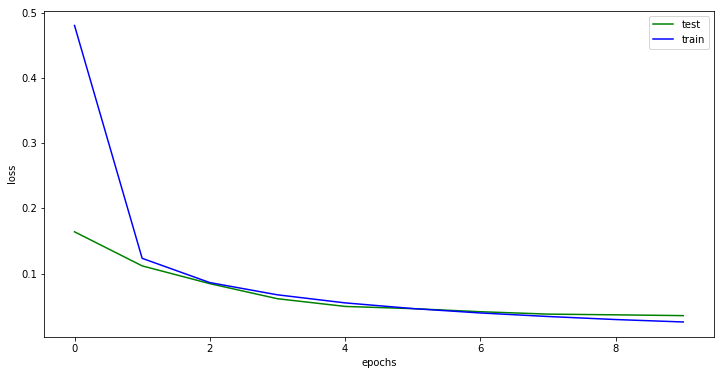


------------- ConvClf BN=True DP=False FC=(1024, 10) -------------



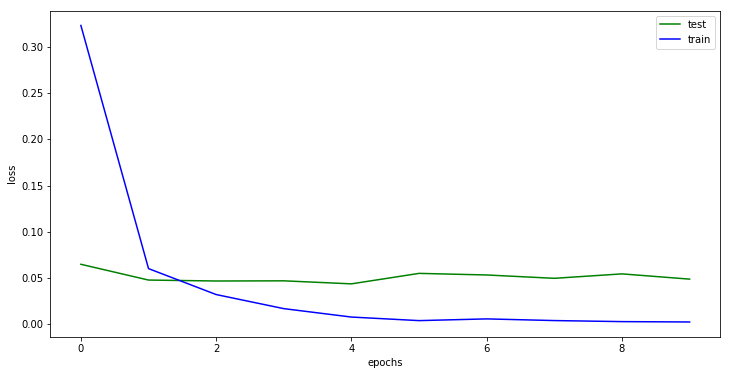


------------- ConvClf BN=True DP=True FC=(1024, 10) -------------



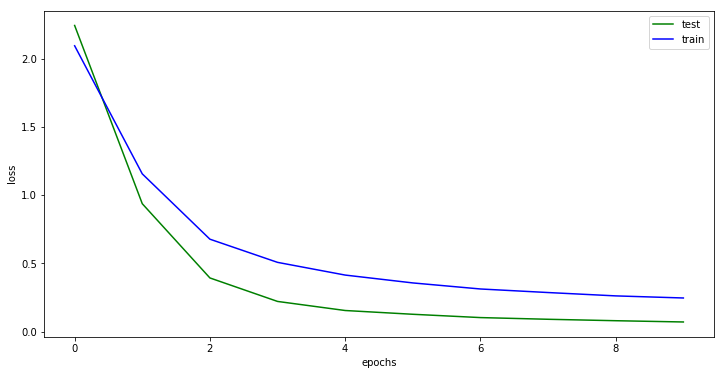

Epoch 11:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.02243 / 0.03574, Accuracy 9890/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00401 / 0.05760, Accuracy 9872/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.23371 / 0.06797, Accuracy 9769/10000
Epoch 12:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.01908 / 0.03705, Accuracy 9886/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00242 / 0.05367, Accuracy 9881/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.22097 / 0.06192, Accuracy 9786/10000
Epoch 13:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.01626 / 0.03433, Accuracy 9892/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00342 / 0.06113, Accuracy 9865/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.20698 / 0.05799, Accuracy 9804/10000
Epoch 14:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.01367 / 0.03440, Accuracy 9

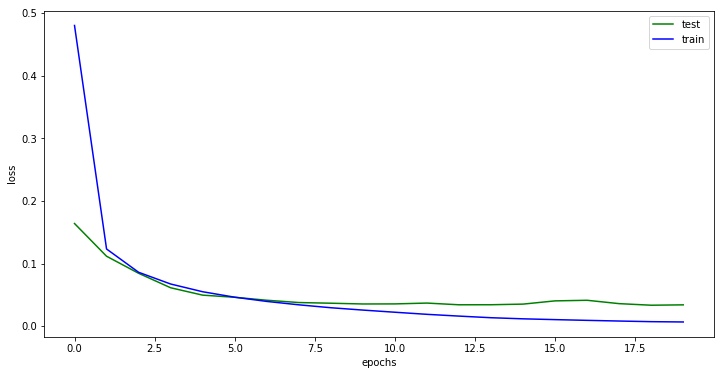


------------- ConvClf BN=True DP=False FC=(1024, 10) -------------



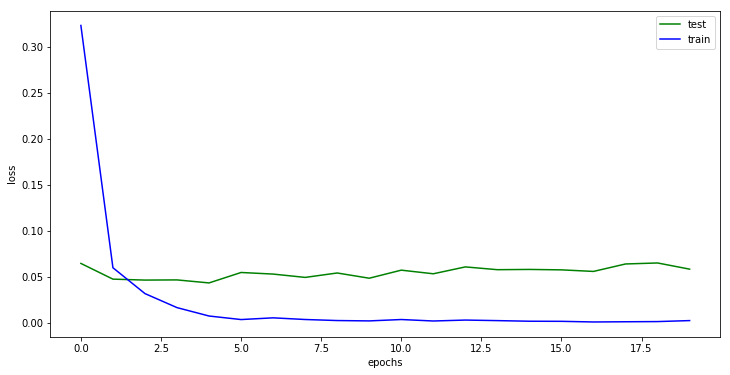


------------- ConvClf BN=True DP=True FC=(1024, 10) -------------



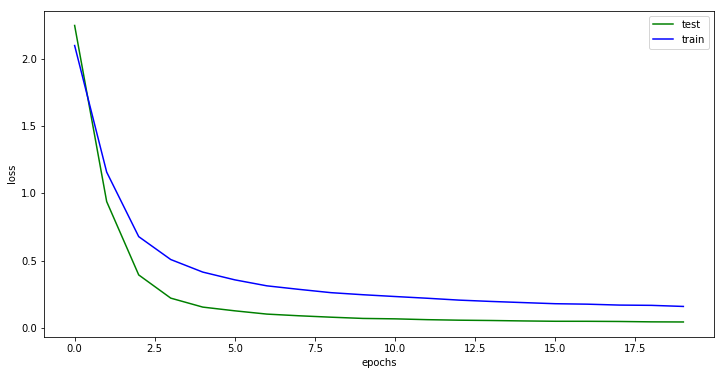

CPU times: user 10min 18s, sys: 10.9 s, total: 10min 29s
Wall time: 10min 29s


In [17]:
%%time
for epoch in range(1, 21):
    losses = train(models, train_dl, test_dl)
    
    for i, (trn, tst) in enumerate(losses):
        train_losses[i].append(trn)
        test_losses[i].append(tst)
    
    if epoch % 10 == 0:
        for i, m in enumerate(models):
            print(f"\n------------- {m.name} -------------\n")
            plot_losses(train_losses[i], test_losses[i])



In [18]:
for m in models:
    torch.save(m.state_dict(), PATH / f'{m.name}.model')

### Train loss

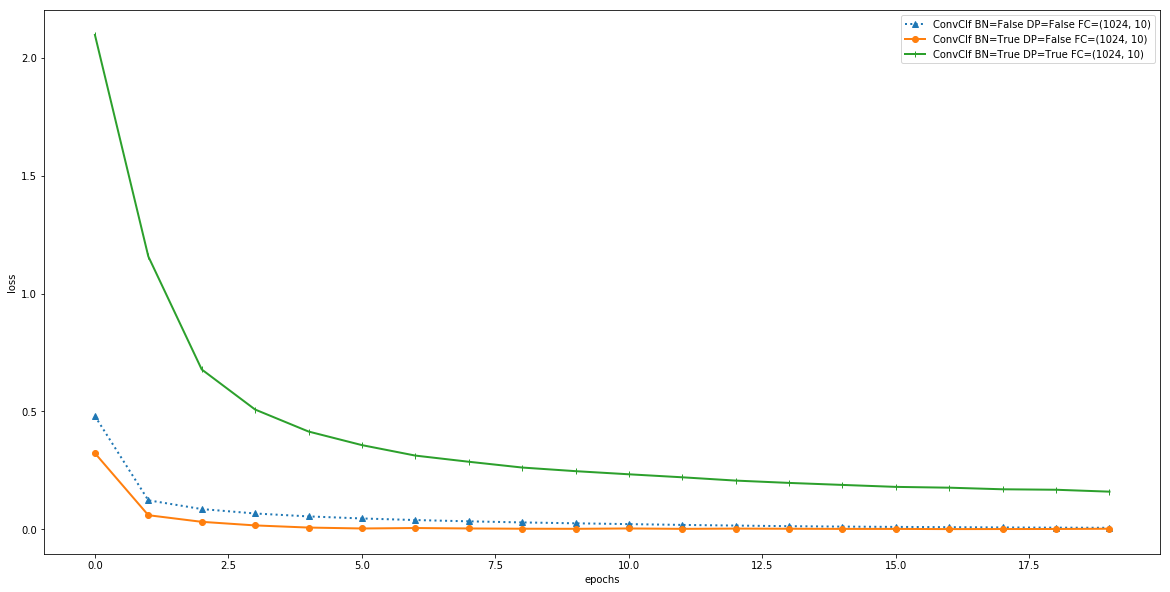

In [19]:

plt.figure(figsize=(20,10))

for i, m in enumerate(models):
    line = train_losses[i]
    if "FC=None" in m.name:
        plt.plot(line, label=m.name, linestyle='-',
        linewidth=4)
    elif "BN=True" in m.name and "DP=False" in m.name:
        plt.plot(line, label=m.name, marker='o', linestyle='-',
        linewidth=2, markersize=6)
    elif "BN=True" in m.name and "DP=True" in m.name:
        plt.plot(line, label=m.name, marker='|', linestyle='-',
        linewidth=2, markersize=6)
    else:
        plt.plot(line, label=m.name, marker='^', linestyle=':',
        linewidth=2, markersize=6)
        
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

### Test loss

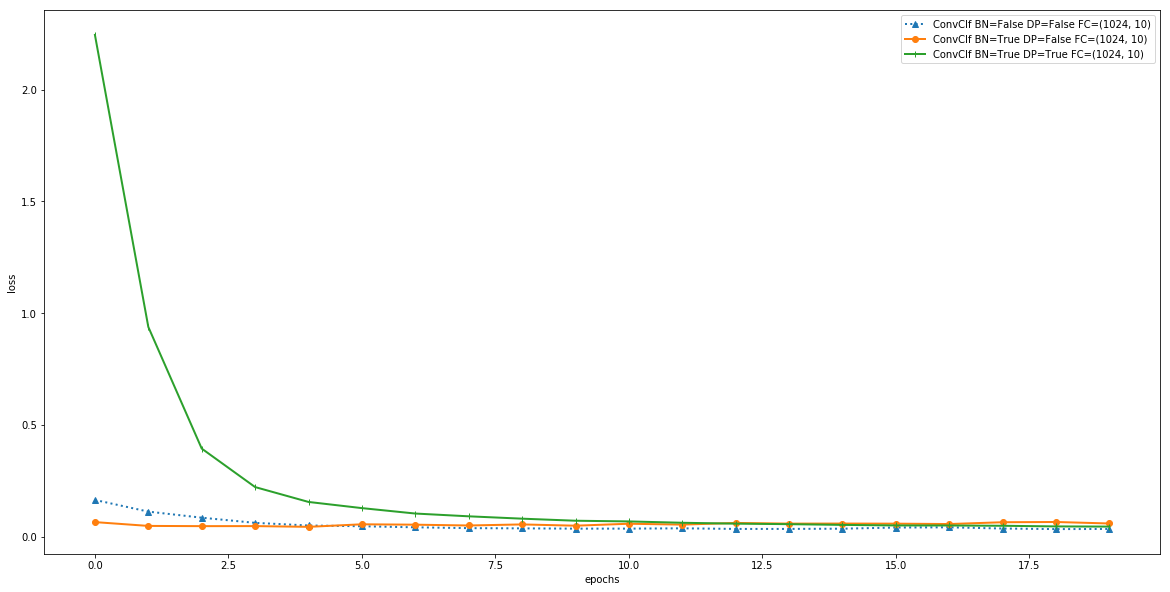

In [20]:
plt.figure(figsize=(20,10))

for i, m in enumerate(models):
    line = test_losses[i]
    if "FC=None" in m.name:
        plt.plot(line, label=m.name, linestyle='-',
        linewidth=4)
    elif "BN=True" in m.name and "DP=False" in m.name:
        plt.plot(line, label=m.name, marker='o', linestyle='-',
        linewidth=2, markersize=6)
    elif "BN=True" in m.name and "DP=True" in m.name:
        plt.plot(line, label=m.name, marker='|', linestyle='-',
        linewidth=2, markersize=6)
    else:
        plt.plot(line, label=m.name, marker='^', linestyle=':',
        linewidth=2, markersize=6)
        
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [89]:
class FitImageToActivationModel(nn.Module):
    def __init__(self, image, target_activation, clip_fn=F.tanh, a_fn=F.sigmoid):
        super().__init__()
        self.a_fn = a_fn
        self.image = nn.Parameter(image)
        self.target_activation = target_activation
        self.optim = optim.Adam(self.parameters(), lr=1e-2)
        self._loss = None
        self.clip_fn = clip_fn if clip_fn else lambda x: x
        
    def forward(self, encoder):
        x = self.image
        out = self.a_fn(encoder(self.clip_fn(x)))
        return out
    
    def loss(self, output):
        n = self.image.shape[0]
        self._loss = F.mse_loss(output.view(-1, n), self.target_activation)
        return self._loss

In [90]:
target_activation = torch.eye(16).to(device)

In [91]:
encoder = models[1].cnn[0]
encoder.eval()
encoder

ConvLayer(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [92]:
r = (-2)*torch.rand(16, 1, 3, 3)+1
origin = torch.tensor(r)

In [93]:
encoder.eval()

ms = {
    'sigmoid': FitImageToActivationModel(r.to(device), target_activation, a_fn = F.sigmoid)
}

opt_losses = [[] for i in range(len(ms))]

for m in ms.values():
    m.to(device).train()

for i in range(1, 20_001):
    losses = [0.0]*len(ms)
    for j , m in enumerate(ms.values()):
        m.optim.zero_grad()
        out = m(encoder)
        loss = m.loss(out)
        loss.backward()
        m.optim.step()
        losses[j]+=loss.item()
    if i % 5_000 == 0:
        for k in range(len(ms)):
            opt_losses[k].append(losses[k])
        s = ["\t{0:10s} = {1:2.10f}\n".format(m, losses[j]) for j , m in enumerate(ms)]
        line = f"{int(i/1000)}K iteration loss: \n{' '.join(s)}"
        print(line)
        losses = [0.0]*len(ms)

5K iteration loss: 
	sigmoid    = 0.2781758606

10K iteration loss: 
	sigmoid    = 0.2781708241

15K iteration loss: 
	sigmoid    = 0.2781547904

20K iteration loss: 
	sigmoid    = 0.2781629562



In [94]:
for m in ms.values():
    m.eval()
target_imgs = {k: m.image.detach() for k, m in ms.items()}
target_imgs['original']=origin.to(device)

original


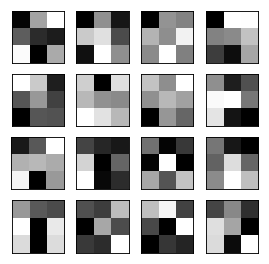

In [95]:
print('original')
plot_mnist(target_imgs['original'].data.cpu().numpy(), (4,4))

sigmoid


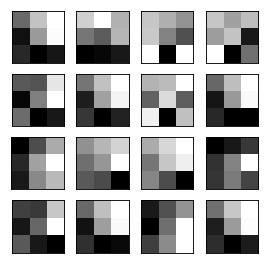

In [96]:
print('sigmoid')
plot_mnist(F.tanh(target_imgs['sigmoid']).data.cpu().numpy(), (4,4))